In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Importing data

We are first loading the train and test data.

In [2]:
train_file_path = 'lab2_train.csv'
test_file_path = 'lab2_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

### What properties of the data do you think are important for your pipeline design?

By visualizing the pairs of likes between users, we can see that users with higher IDs (potentially new users in the system) are not interacting a lot with users with lower IDs (older users in the system). This might mean the system did not recommend users registered earlier to new registered users, maybe due to the inactivity of older users.

The idea that higher IDs suggest more recent users in the system is also supported by the sparsity of the data towards higher IDs. The users joined recently, so they did not have many interactions with the other users in the system.

There is some weird behaviour happening for users with higher IDs, we can see an exponential curve, with somewhat noticeable density around this curve...

# TODO explain why it is important for the pipeline

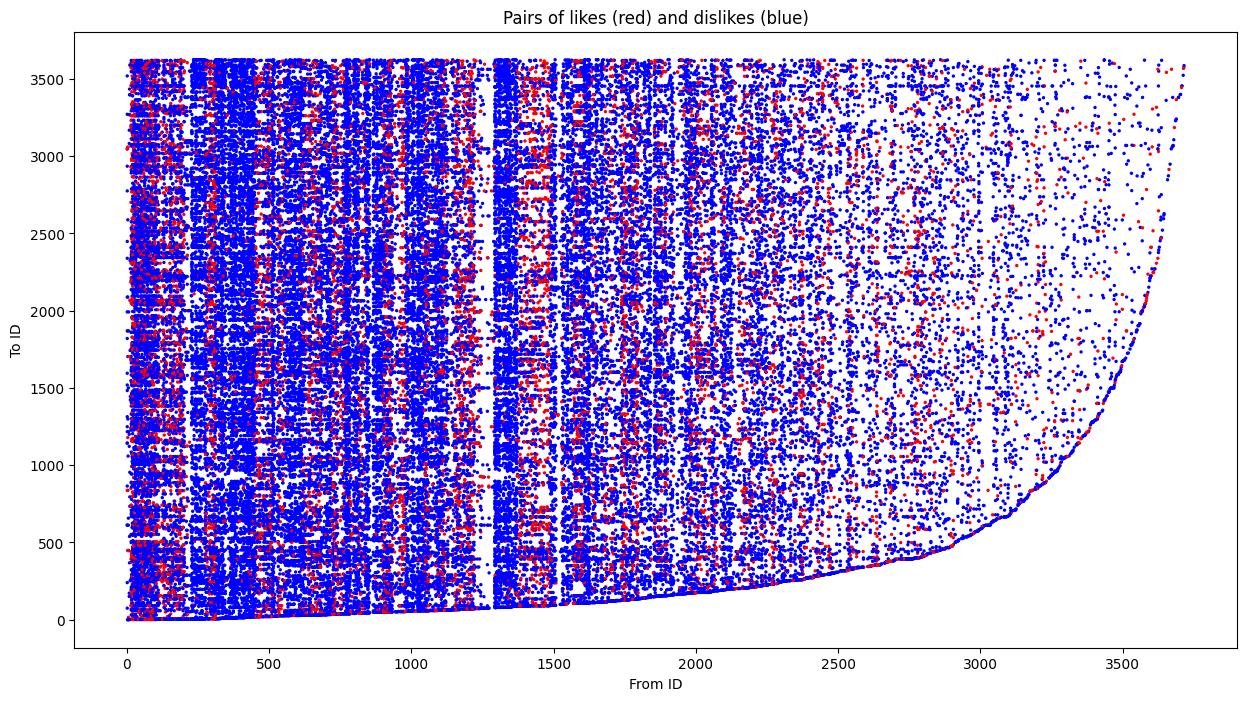

In [3]:
is_like = train_data['is_like'].to_numpy()

colors = ['red' if v else 'blue' for v in is_like]
# 'red' -> 'Like', 'blue' -> 'Dislike'

plt.figure(figsize=(15, 8))
plt.scatter(x=train_data['user_from_id'], y=train_data['user_to_id'], c=colors, s=2)
plt.xlabel('From ID')
plt.ylabel('To ID')
plt.title('Pairs of likes (red) and dislikes (blue)')

plt.show()

### 2. Do you see different types of people (in terms of both which id pairs are present and what they like/don’t like)?


From the input data (at least, the first 2000 ids), we can draw some conclusions regarding the types of people on Breeze:
- The inactive users: at around id 1200, there was an influx of users that did not send (m)any match requests. 
(We can assume that they are either bots, or users that uninstalled/didn't use the app)
- The "unlucky" users: from the plot, there are blue stripes occurring from time to time. That represents the users that
did not find a match, even though they liked most users they came across.
- The "angry" users: there are also gray stripes, representing users that did not like users they ran into, and they also
weren't liked back.

When talking about more recent users, the data is too sparse to draw an accurate conclusion.

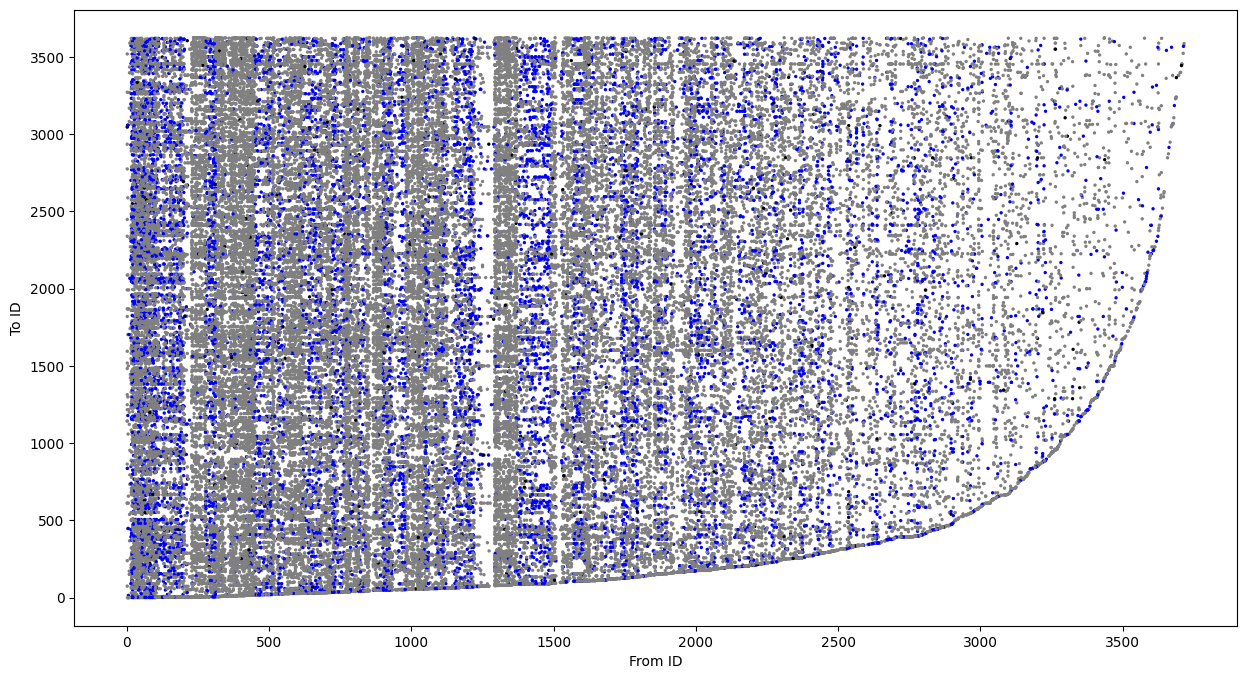

In [4]:
is_like = train_data['is_like'].to_numpy()
is_match = train_data['is_match'].to_numpy()

colors = []
for i in range(len(is_like)):
    if is_match[i] == 1:
        colors.append('black')
    elif is_like[i] == 1:
        colors.append('blue')
    else:
        colors.append('gray')

plt.figure(figsize=(15, 8))
plt.scatter(x=train_data['user_from_id'], y=train_data['user_to_id'], c=colors, s=2)

plt.xlabel('From ID')
plt.ylabel('To ID')

plt.show()

In [5]:
train_data

,user_from_id,user_to_id,is_like,is_match
0,1136,3141,False,False
1,2424,3174,False,False
2,1300,3590,False,False
3,800,2736,False,False
4,883,437,False,False
...,...,...,...,...
76387,2376,3057,False,False
76388,1163,933,False,False
76389,2770,3324,False,False
76390,879,785,False,False


In [6]:
test_data

,user_from_id,user_to_id,is_like,is_match
0,2644,2595,?,?
1,567,2412,?,?
2,2732,3187,?,?
3,783,854,?,?
4,1104,2723,?,?
...,...,...,...,...
16198,2197,1449,?,?
16199,2507,316,?,?
16200,511,889,?,?
16201,2148,2947,?,?


### Non-negative matrix factorization

The code cell below contains the Weblab submission.

In [7]:
def reconstruction_error(X: pd.DataFrame, W: pd.DataFrame, H: pd.DataFrame):
    """
    Compute the reconstruction error E = || V - WH || ^ 2. NaN values (missing values) in X do not contribute towards the error.
    """
    return np.nansum((X - W @ H) ** 2)
    

def nmf(X: pd.DataFrame, n_components: int, max_iter: int=1000, tol: float=1e-4, debug_steps: bool=False):
  """
  Decomposes the original sparse matrix X into two matrices W and H. 
  """
  # Initialize W and H with random non-negative values
  W = np.random.rand(X.shape[0], n_components)
  H = np.random.rand(n_components, X.shape[1])

  curr_iter = 0
  prev_error = reconstruction_error(X, W, H)
  epsilon = 1e-9   
  
  # NaN values are treated as 0 in the multiplication
  X_without_nan = X.fillna(0)
  
  while curr_iter < max_iter:
    H = H * (W.T @ X_without_nan) / ((W.T @ W @ H) + epsilon)
    W = W * (X_without_nan @ H.T) / ((W @ H @ H.T) + epsilon)
    
    # NaN values have no loss contribution
    curr_error = reconstruction_error(X, W, H)
    if debug_steps:
        print(f'iteration {curr_iter}, error {curr_error}')
    
    if abs(curr_error - prev_error) < tol:
      break
        
    prev_error = curr_error
    curr_iter += 1

  return W, H

#### Pre-processing - Dealing with duplicates

We use majority vote to deal with duplicate interactions between users (e.g. user X first liked user Y, then user X disliked user Y). If between 2 users there are fewer likes than dislikes, then we count it as a dislike, otherwise a like. If the data had timestamps, we could have simply taken the most recent interaction between the 2 users.

In [9]:
def solve_duplicates(data: pd.DataFrame):
    # for each user IDs pair count the number of likes and total interactions
    grouped_data = data.groupby(['user_from_id', 'user_to_id']).agg({'is_like': ['sum', 'count']}).reset_index()
    
    unique_data = []
    
    for index, row in grouped_data.iterrows():
        # for each pair get the user ids, like and dislike counts
        a = row['user_from_id'].iloc[0]
        b = row['user_to_id'].iloc[0]
        like_count = int(row['is_like']['sum'])
        dislike_count = int(row['is_like']['count']) - like_count    
        
        if like_count < dislike_count:
            row = pd.Series({'user_from_id':a, 'user_to_id':b, 'is_like':0})
        else:
            row = pd.Series({'user_from_id':a, 'user_to_id':b, 'is_like':1})
            
        unique_data.append(row)   
    
    return pd.DataFrame(unique_data)
    
    
unique_train_data = solve_duplicates(train_data)
print(f'Removed {train_data.shape[0] - unique_train_data.shape[0]} duplicates.')

Removed 4251 duplicates.


### Pre-processing - Creating the utility matrix
Next, we use the `unique_train_data` to create an NxN `utility_matrix`, where N is the maximum user ID and initialize it with NaN values. Then we set the elements corresponding to likes/dislikes with numerical values 1 or 0. This means we don't need normalization, since we are only dealing with discrete values 0 and 1, and they are included in the interval [0, 1] used for the randomization of W and H.



In [10]:
def build_utility_matrix(data: pd.DataFrame, max_user_id: int = 0):
    # the size of the matrix depends on the largest user ID
    if max_user_id == 0:
        max_user_id = max(data['user_from_id'].max(), data['user_to_id'].max())
    
    # create an empty utility matrix with NaN values
    utility_matrix = np.full((max_user_id + 1, max_user_id + 1), np.nan)
    
    # set the corresponding likes/dislikes
    for index, row in data.iterrows():
        a = row['user_from_id']
        b = row['user_to_id']
        is_like = row['is_like']
                
        utility_matrix[a, b] = is_like
    
    return pd.DataFrame(utility_matrix)
    
utility_matrix = build_utility_matrix(unique_train_data)
print(utility_matrix.shape)

(3717, 3717)



### TODO
- Are there corrupted values? How do you deal with them?
Nope
- What do you do about users who gave/received very few likes? removal of outliers, users with very few “like”s or “don’t like”s
Is it necessary to remove empty rows and columns ?

In [59]:
# TODO ? Remove empty rows and columns
# empty_rows = np.all(np.isnan(utility_matrix), axis=1)
# empty_columns = np.all(np.isnan(utility_matrix), axis=0)
# 
# utility_matrix = utility_matrix[~empty_rows, :]
# utility_matrix = utility_matrix[:, ~empty_columns]
# 
# print(utility_matrix.shape)

not_nan_count_per_row = utility_matrix.shape[0] - utility_matrix.isna().sum(axis=1)
not_nan_count_per_column = utility_matrix.shape[1] - utility_matrix.isna().sum()

print(np.count_nonzero(not_nan_count_per_row < 7))
print(np.count_nonzero(not_nan_count_per_column < 7))

utility_matrix = utility_matrix.drop(not_nan_count_per_row < 7)
utility_matrix = utility_matrix.drop(columns=not_nan_count_per_column < 7)
print(utility_matrix.shape)

1452
1474


KeyError: '[True, False, True, False, True, True, True, True, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, True, True, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, True, False, False, False, False, False, False, False, False, False, False, True, True, True, False, True, True, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, True, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, True, True, True, True, True, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, True, True, False, False, False, False, True, False, True, False, True, False, False, False, False, True, False, False, True, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, True, False, True, False, False, False, False, True, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, True, False, True, True, False, True, True, False, True, False, False, True, False, False, True, True, True, False, False, False, False, True, False, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, False, True, False, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, True, True, True, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, True, False, True, False, False, False, False, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, True, True, False, False, False, False, True, False, False, False, False, False, True, True, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, True, False, False, False, False, False, True, False, True, False, False, True, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, False, True, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, True, False, True, False, False, False, False, False, False, False, True, False, False, True, False, True, False, False, True, False, False, False, True, False, True, False, True, False, False, False, True, False, False, False, False, False, True, False, False, False, False, True, True, True, True, True, True, True, True, True, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, True, False, False, True, True, True, True, False, False, False, False, False, False, True, False, False, True, False, False, False, True, True, False, True, True, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, True, True, True, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, False, True, True, True, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, True, True, False, False, False, True, False, True, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, True, False, True, True, False, False, False, False, False, True, False, False, False, False, False, True, False, True, True, True, False, False, False, True, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, True, False, True, True, True, True, False, True, False, True, False, False, False, True, False, True, False, False, False, False, False, False, False, True, False, True, False, False, True, False, False, True, False, False, False, True, True, True, False, False, False, False, False, False, False, False, True, False, False, True, False, True, True, False, False, False, True, False, False, True, False, False, True, True, False, True, True, True, False, False, True, False, True, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, False, True, True, False, True, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, False, False, True, False, True, False, False, False, False, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, True, True, False, True, True, False, True, False, False, True, False, False, False, True, False, False, False, True, False, False, False, False, False, False, True, True, False, False, True, True, True, False, False, True, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, True, False, False, True, True, False, False, False, False, False, False, True, False, True, True, False, True, False, True, True, False, False, True, True, True, True, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, False, True, True, False, False, True, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, True, False, True, True, False, True, False, True, True, False, False, True, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, True, True, True, False, True, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, True, True, True, False, False, False, False, False, False, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, True, False, True, False, True, True, False, True, True, True, False, True, True, True, False, False, False, True, True, True, False, True, True, True, True, False, False, False, False, False, True, True, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, True, True, False, False, False, False, False, True, True, False, False, False, True, False, False, True, False, True, False, True, False, True, False, True, True, False, True, True, True, False, False, False, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, False, True, True, False, False, True, False, False, True, False, True, False, False, True, False, False, False, True, True, True, False, False, False, True, False, False, False, False, False, False, False, False, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, False, False, True, False, True, False, True, True, False, True, False, False, True, True, True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, False, False, True, False, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, False, True, True, False, True, False, False, True, False, True, True, True, True, True, True, False, True, False, True, False, False, False, True, True, True, False, True, False, True, False, False, True, True, False, False, False, True, False, False, False, True, False, True, True, False, True, True, True, False, False, True, False, False, True, True, False, False, False, True, False, True, False, True, True, False, False, False, True, True, True, False, True, True, False, True, True, True, True, True, False, False, False, False, True, False, False, True, False, True, True, False, True, False, True, True, False, True, False, True, True, True, True, True, False, False, True, True, True, True, False, False, True, True, True, True, False, False, False, False, True, True, True, True, True, False, True, False, False, False, True, True, True, False, True, False, True, False, False, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, False, True, True, True, True, True, False, False, False, True, True, True, True, True, False, False, False, False, True, True, False, True, True, True, True, True, True, True, False, False, True, True, False, False, False, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, False, False, True, True, True, True, True, False, True, True, True, False, False, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, False, True, True, True, False, True, True, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, False, True, False, False, False, False, True, True, True, True, False, True, True, False, True, False, True, True, False, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, False, False, False, True, True, False, True, True, False, False, False, True, True, True, False, True, True, False, True, False, False, False, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, False, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True] not found in axis'

#### Fine tuning

In order to choose the hyperparameter k, the number of features used in NMF, we use 5-fold cross-validation. One fifth of the set is the validation set and the rest is used for training. After computing NMF, we evaluate the reconstruction error by comparing the utility matrix of the validation set to the reconstructed matrix computed based on the train set. We average these errors for all 5 folds to obtain the final cross-validation score.

In [21]:
def cross_validate(data: pd.DataFrame, max_user_id: int, n_components: int, num_folds: int = 10):
    # shuffle row indices in the data set
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    fold_size = len(data) // num_folds
    cv_scores = []
    
    for i in range(num_folds):
        # calculate the indices of the current fold
        fold_start = i * fold_size
        fold_end = (i + 1) * fold_size
        if i == num_folds - 1:
            fold_end = len(data)
        
        # select the current train and validation sets with random indices
        curr_validation_data = data.iloc[indices[fold_start:fold_end]]
        curr_train_data = pd.concat([data.iloc[indices[:fold_start]], data.iloc[indices[fold_end:]]])
        
        # build the utility matrices for both the train and the validation sets
        train_utility_matrix = build_utility_matrix(curr_train_data, max_user_id=max_user_id)
        validation_utility_matrix = build_utility_matrix(curr_validation_data, max_user_id=max_user_id)
        
        # run NMF on the train set, set max iterations to 100 to lower runtime
        W, H = nmf(train_utility_matrix, n_components=n_components, max_iter=100)
        
        # evaluate the reconstruction error on the validation set
        validation_reconstruction_error = reconstruction_error(validation_utility_matrix, W, H)        
        cv_scores.append(validation_reconstruction_error)
    
    return np.array(cv_scores).mean()

The code cell below performs 5-fold cross-validation for values of k between 2 and 14. To reduce the runtime, we set an upper bound of 100 on the iterations of NMF. With this trick, we managed to lower the runtime to ~20 minutes.

100%|██████████| 13/13 [26:54<00:00, 124.19s/it]


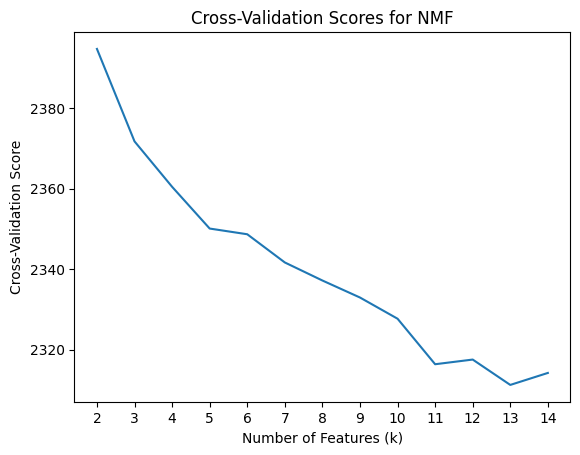

In [22]:
overall_max_user_id = max(train_data['user_from_id'].max(), train_data['user_to_id'].max())

cv_scores = []

for i in tqdm(range(2, 15)):
    cv_score = cross_validate(unique_train_data, overall_max_user_id, n_components=i, num_folds=5)   
    cv_scores.append(cv_score)

plt.plot(cv_scores)
plt.xticks(np.arange(len(cv_scores)), np.arange(2, len(cv_scores)+2))
plt.xlabel('Number of Features (k)')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores for NMF')
plt.show()

### Run NMF

Based on the results of 5-fold cross-validation and the Elbow method, we decided on using 8 features. Now let's see what the reconstruction error is for the entire train set.

### TODO 
Explain the choice of number of features, max iterations and error tolerance.
Decide on a recommendation threshold based on the NMF reconstruction and explain your decision

In [11]:
W, H = nmf(utility_matrix, 8, debug_steps=True)

print(reconstruction_error(utility_matrix, W, H))

iteration 0, error 12012.805557711657
iteration 1, error 11876.696123489312
iteration 2, error 11745.566538190065
iteration 3, error 11531.10155938866
iteration 4, error 11309.835741963128
iteration 5, error 11151.005400322427
iteration 6, error 11051.510842557582
iteration 7, error 10989.25513476678
iteration 8, error 10947.822793421876
iteration 9, error 10917.638840836911
iteration 10, error 10894.212822510111
iteration 11, error 10875.563469027793
iteration 12, error 10860.617378906201
iteration 13, error 10848.459301041805
iteration 14, error 10838.248583060853
iteration 15, error 10829.32264502287
iteration 16, error 10821.383592482927
iteration 17, error 10814.344444369897
iteration 18, error 10808.112861392741
iteration 19, error 10802.642956953678
iteration 20, error 10797.914447636547
iteration 21, error 10793.871601209725
iteration 22, error 10790.409958469661
iteration 23, error 10787.431027629023
iteration 24, error 10784.80478008942
iteration 25, error 10782.389669618513


In [47]:
predicted = W @ H
predicted = np.where(predicted >= 0.3, 1, 0)

print(np.count_nonzero(~utility_matrix.isna() & utility_matrix != predicted))
print(np.nansum((utility_matrix - predicted) ** 2))
print(np.count_nonzero(predicted == 1))
print(np.count_nonzero(utility_matrix == 1))

12632
11914.0
1683
12613


### Minhashing

In [31]:
import numpy as np
import sys
from library import HashFunction


def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """

    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)
    for ix,r in enumerate(sorted_space):
        for c in range(result.shape[1]):
            if r in ids[c]:
                for i, hf in enumerate(hashes):
                    result[i][c] = min(result[i][c], hf.hashf(ix, len(sorted_space)))

    return result

[]

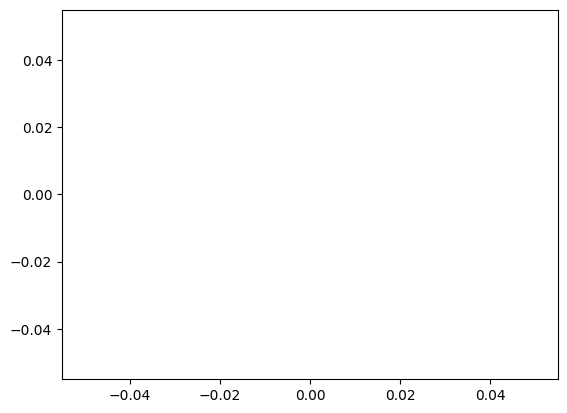

In [32]:

plt.plot()
